In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt
from datetime import timedelta  

import lightgbm as lgb
from sklearn.model_selection import KFold

In [2]:
train = pd.read_csv('TRAIN_PREPARED.csv')
test = pd.read_csv('TEST_PREPARED.csv')
add_i = pd.read_csv('TRAIN_ADDITIONAL_DATA.csv')
add_i_test = pd.read_csv('TEST_ADDITIONAL_DATA.csv')

## EDA
First lets take a look at the size of our data set and try to understand what type of features i have

In [3]:
train.shape

(180249, 146)

Check what is the most popular data type

In [4]:
types = pd.DataFrame(train.dtypes)
types['instance'] = 1
types.groupby(0).sum()

,instance
0,
int64,1
float64,141
object,4


No missing values

In [6]:
train.isna().sum()>0

cut_date                    False
days_to_end                 False
email                       False
first_date                  False
last_date                   False
num_country_max_1days       False
num_city_max_1days          False
android_max_1days           False
smarttv_max_1days           False
iphone_max_1days            False
ipad_max_1days              False
apple_max_1days             False
pc_max_1days                False
time_spent_sum_3days        False
time_spent_max_3days        False
num_title_ep_sum_3days      False
num_title_ep_max_3days      False
num_title_ru_sum_3days      False
num_title_ru_max_3days      False
num_country_max_3days       False
num_city_max_3days          False
other_content_sum_3days     False
top_1_sum_3days             False
top_2_sum_3days             False
top_3_sum_3days             False
top_4_sum_3days             False
top_5_sum_3days             False
top_6_sum_3days             False
top_7_sum_3days             False
top_8_sum_3day

Easy look at the data

In [7]:
train.head()

,cut_date,days_to_end,email,first_date,last_date,num_country_max_1days,num_city_max_1days,android_max_1days,smarttv_max_1days,iphone_max_1days,...,apple_max_30days,pc_max_30days,activity_1to3,activity_1to7,activity_1to14,activity_7to14,activity_7to21,activity_7to30,activity_14to30,label
0,2019-04-02 00:00:00,11,8ba752f2c5,2019-02-10 00:00:00,2019-03-13 09:36:59,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,2019-04-02 00:00:00,10,752a6d96f7,2018-10-28 00:00:00,2019-04-01 20:51:29,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.005807,0.005774,0.003030,0.521792,1.0
2,2019-04-02 00:00:00,4,827f6afef3,2018-12-14 00:00:00,2019-04-01 18:00:49,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.937031,0.832238,0.598121,0.638308,0.0
3,2019-04-02 00:00:00,9,346e0f766c,2019-03-08 00:00:00,2019-03-31 23:05:17,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.540452,0.536714,0.316218,0.585099,1.0
4,2019-04-02 00:00:00,10,0addbcc79a,2019-01-09 00:00:00,2019-03-25 17:41:09,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.418660,0.0


Tying to understan what type of data i have: so as i can see there is a time series data

In [8]:
train['email'].nunique()

20000

It is clearly that columns first_date,last_date the same for every entry of the user 

In [9]:
train[train['email'] == '0addbcc79a'].head()

,cut_date,days_to_end,email,first_date,last_date,num_country_max_1days,num_city_max_1days,android_max_1days,smarttv_max_1days,iphone_max_1days,...,apple_max_30days,pc_max_30days,activity_1to3,activity_1to7,activity_1to14,activity_7to14,activity_7to21,activity_7to30,activity_14to30,label
4,2019-04-02 00:00:00,10,0addbcc79a,2019-01-09 00:00:00,2019-03-25 17:41:09,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.418660,0.0
8613,2019-04-11 00:00:00,1,0addbcc79a,2019-01-09 00:00:00,2019-03-25 17:41:09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
16586,2019-04-09 00:00:00,3,0addbcc79a,2019-01-09 00:00:00,2019-03-25 17:41:09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
23057,2019-03-30 00:00:00,13,0addbcc79a,2019-01-09 00:00:00,2019-03-25 17:41:09,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.741795,0.741795,0.416767,0.561835,0.0
28095,2019-04-03 00:00:00,9,0addbcc79a,2019-01-09 00:00:00,2019-03-25 17:41:09,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.418660,0.0


Lets take a look at the labels

In [9]:
train['label'].nunique()

2

Unbalanced classes

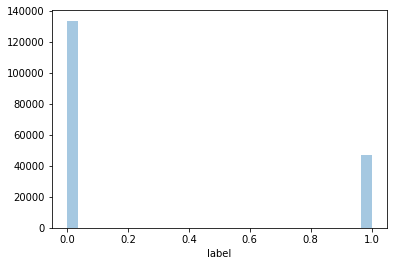

In [10]:
sns.distplot(train['label'],kde = False) 

apple_max_21days


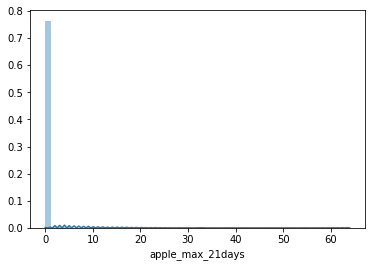

other_content_sum_30days


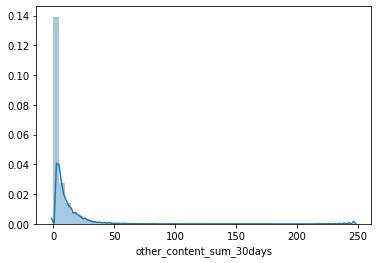

apple_max_7days


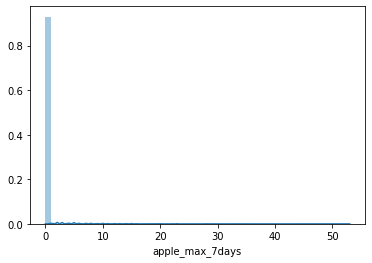

days_to_end


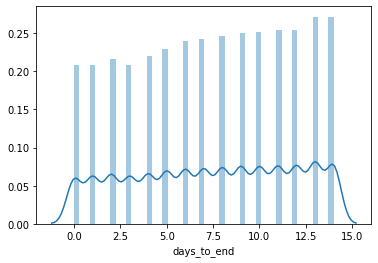

num_title_ep_max_14days


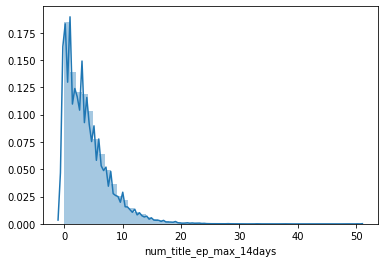

num_title_ru_sum_7days


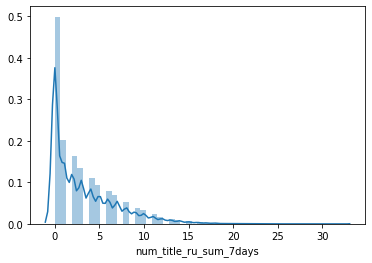

num_title_ep_sum_3days


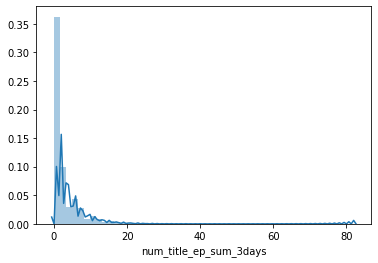

iphone_max_7days


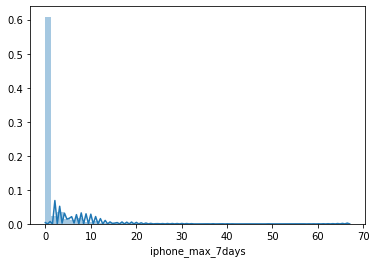

num_title_ru_sum_14days


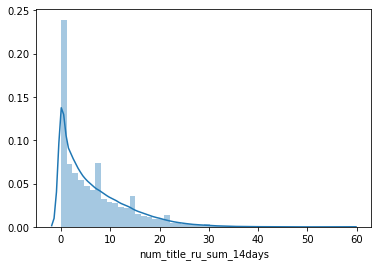

num_country_max_21days


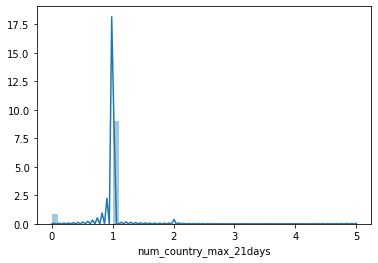

top_9_sum_14days


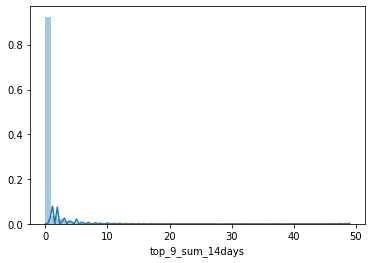

num_city_max_21days


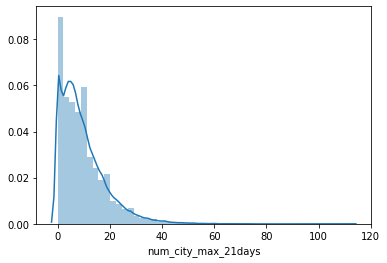

time_spent_sum_3days


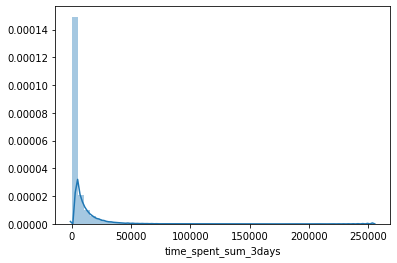

top_5_sum_30days


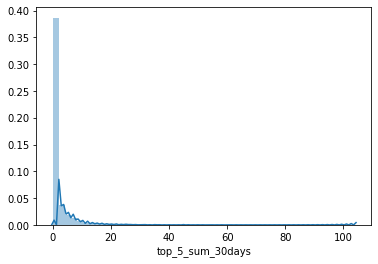

top_4_sum_14days


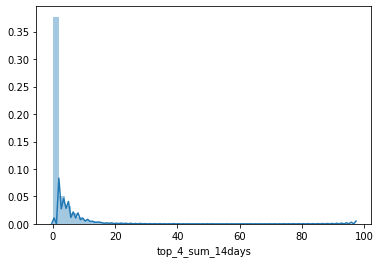

top_8_sum_21days


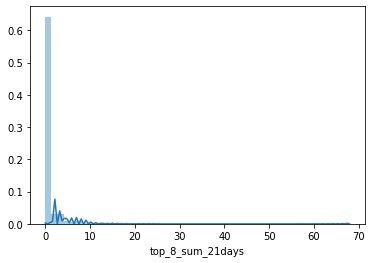

pc_max_14days


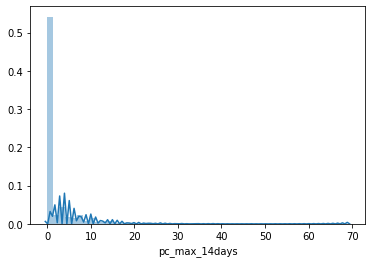

top_9_sum_3days


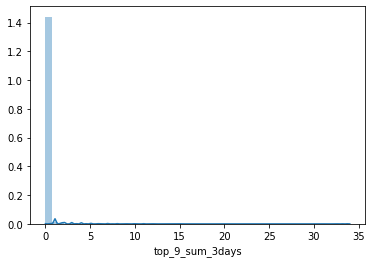

top_4_sum_3days


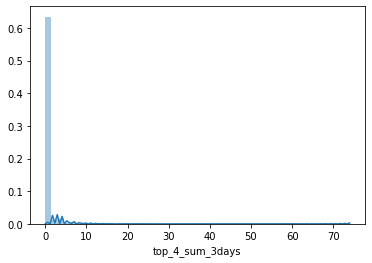

top_5_sum_7days


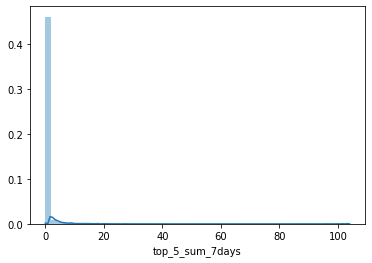

pc_max_21days


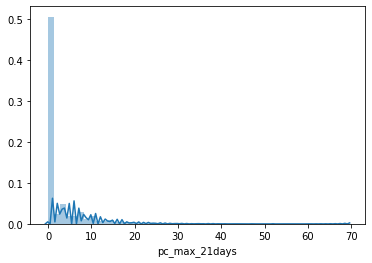

num_title_ru_max_14days


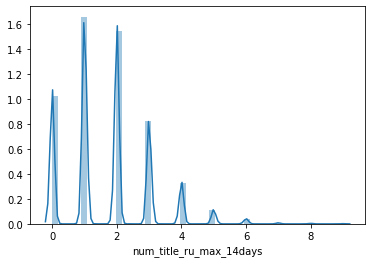

num_title_ep_sum_30days


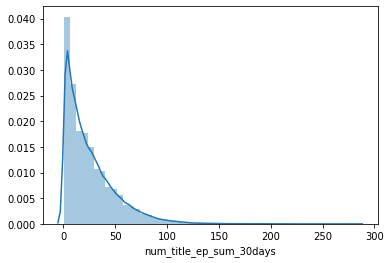

time_spent_max_3days


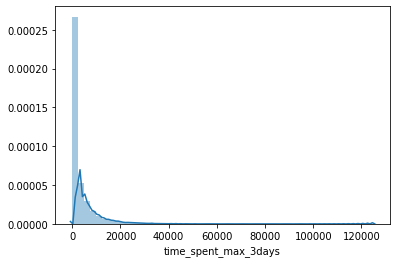

num_title_ru_sum_3days


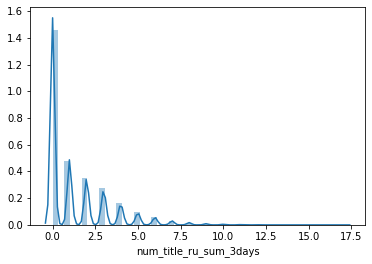

smarttv_max_7days


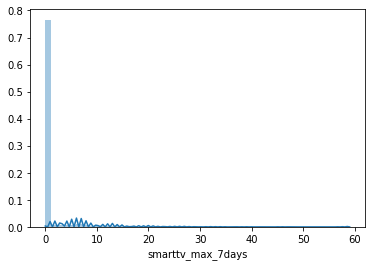

In [ ]:
cols = list(set(list(train.columns)) - set(['cut_date','first_date','last_date','email']))
for i in cols :
    print(i)
    sns.distplot(train[i],kde = True)
    plt.show()

### Feature Engineering 

In [5]:
train['Timedelta'] = (pd.to_datetime(train['last_date']) - pd.to_datetime(train['first_date'])).apply(lambda x:(x.days * 24*3600 + 
                                                                                 x.seconds)/(3600*24) )

test['Timedelta'] = (pd.to_datetime(test['last_date']) - pd.to_datetime(test['first_date'])).apply(lambda x:(x.days * 24*3600 + 
                                                                                 x.seconds)/(3600*24) )

In [6]:
train.drop(columns = ['first_date','last_date'],inplace = True)
test.drop(columns = ['first_date','last_date'],inplace = True)

In [7]:
#train['cut_date'] = (train['cut_date']).apply(lambda x: pd.to_datetime(x))

Create features from additional data

In [8]:
def features_cat(df,group_by, cat_list, name_df):
    # select the categorical features
    # and do one hot encoding
    a = list(df.select_dtypes(object).columns)
    a.remove('email')
    g_b = df[group_by]
    if df.select_dtypes(object).shape[1]:
        features = pd.get_dummies(df[a]) 
        features[group_by] = g_b
        features[group_by] = df[group_by]

      # groupby, take the statistics and create the group_by index to columns 
        df_cat = features.groupby(by = group_by).agg(cat_list).reset_index()
      
      # create new names of columns
        new_columns = []
        for main_name in df_cat.columns.levels[0]:
            if group_by != main_name:
                for sub_name in df_cat.columns.levels[1][:-1]: # we need to do till [:-1] because we did rese_index()
                    new_columns.append(name_df + "_" + main_name + "_" + sub_name)
        new_columns = [group_by] + new_columns

        df_cat.columns = new_columns
        return df_cat
    else:
        return df[group_by]
def features_agg(df,group_by,agg_list, name_df):
    
    # groupby, take the statistics and create the group_by index to columns        
    df_agg = df.groupby(by = group_by).agg(agg_list).reset_index()
    
    # now we have 2 levels of the features
    # to merge the datasets we need same format
    new_columns = []
    for main_name in df_agg.columns.levels[0]:
        if group_by != main_name:
            for sub_name in df_agg.columns.levels[1][:-1]:
                new_columns.append(name_df + "_" + main_name + "_" + sub_name)
    new_columns = [group_by] + new_columns 
    
    df_agg.columns = new_columns
    return df_agg

The idea is for every client take the day when the client have to update his subscription and then from additional dataset take the difference beetwen every action the day of the updating

In [9]:
edn_data = train['cut_date'].apply(lambda x: pd.to_datetime(x)) + train['days_to_end'].apply(lambda x: timedelta(x))
edn_data = pd.DataFrame(edn_data,columns = ['EndDate'])
edn_data['email'] = train['email']
add_i = add_i.merge(edn_data).drop_duplicates().reset_index(drop = True)
add_i['Time_delta'] = (pd.to_datetime(add_i['EndDate']) - pd.to_datetime(add_i['calday'])).apply(lambda x:(x.days * 24*3600 + 
                                                                                 x.seconds)/(3600*24) )
add_i = add_i.drop(columns = ['calday','EndDate'])

In [10]:
edn_data = test['cut_date'].apply(lambda x: pd.to_datetime(x)) + test['days_to_end'].apply(lambda x: timedelta(x))
edn_data = pd.DataFrame(edn_data,columns = ['EndDate'])
edn_data['email'] = test['email']
add_i_test = add_i_test.merge(edn_data).drop_duplicates().reset_index(drop = True)
add_i_test['Time_delta'] = (pd.to_datetime(add_i_test['EndDate']) - pd.to_datetime(add_i_test['calday'])).apply(lambda x:(x.days * 24*3600 + 
                                                                                 x.seconds)/(3600*24) )
add_i_test = add_i_test.drop(columns = ['calday','EndDate'])

Take the statistics from the additional dataset 

In [11]:
add_i_cat = features_cat(add_i,group_by = 'email', cat_list  = ['count','sum','mean','sem'], name_df = 'add_')
add_i_test_cat = features_cat(add_i_test,group_by = 'email', cat_list  = ['count','sum','mean','sem'], name_df = 'add_')

In [12]:
print(add_i_cat.shape)
print(add_i_test_cat.shape)

(20000, 17)
(10000, 17)


In [13]:
add_i_agg = features_agg(add_i,group_by = 'email',agg_list = ['count', 'mean', 'max', 'min', 'sum','std','sem'], name_df = 'add_')
add_i_test_agg = features_agg(add_i_test,group_by = 'email',agg_list = ['count', 'mean', 'max', 'min', 'sum','std','sem'], name_df = 'add_')


In [14]:
print(add_i_agg.shape)
print(add_i_test_agg.shape)

(20000, 8)
(10000, 8)


### Merge the datasets

In [15]:
train.shape

(180249, 145)

In [16]:
train = train.merge(add_i_cat,on = 'email')
train = train.merge(add_i_agg,on = 'email')

In [17]:
train.shape

(180249, 168)

In [18]:
test.shape

(10000, 144)

In [19]:
test = test.merge(add_i_test_cat,on = 'email')
test = test.merge(add_i_test_agg,on = 'email')

In [20]:
test.shape

(10000, 167)

In [21]:
train.to_csv("train_ac.csv", index=False)
test.to_csv("test_ac.csv", index=False)

### Baseline 
Now i am going to summarise the time series data and create one raw for one custumer

In [42]:
train = pd.read_csv('train_ac.csv')
test = pd.read_csv('test_ac.csv')

In [43]:
print(test.shape)

(10000, 167)


In [44]:
lables = train[['email','label']]

In [45]:
train_base = train.drop(columns = ['cut_date','label'])
test_base = test.drop(columns = ['cut_date'])

In [46]:
train_base = train_base.groupby('email').mean().reset_index()
train_base = train_base.merge(lables,how = 'inner', on = 'email').drop_duplicates()

test_base = test_base.groupby('email').mean().reset_index()


In [47]:
print(train_base.shape)
print(test_base.shape)

(20038, 167)
(10000, 166)


In [48]:
train_base['instance'] = 1

check = train_base[['email','instance']].groupby('email').count()

In [49]:
check[check['instance']>1]

,instance
email,
061c44fa2d,2
06aa53cc06,2
0e85db28df,2
1768cf43f6,2
1e90afa46f,2
25c3eee8d0,2
261965c379,2
264685930b,2
2f383bede0,2


So i there is some mislabled email, leta just drop them

In [50]:
train_base[train_base['email'] == '061c44fa2d' ]

,email,days_to_end,num_country_max_1days,num_city_max_1days,android_max_1days,smarttv_max_1days,iphone_max_1days,ipad_max_1days,apple_max_1days,pc_max_1days,...,add__trial_True_sem,add__Time_delta_count,add__Time_delta_mean,add__Time_delta_max,add__Time_delta_min,add__Time_delta_sum,add__Time_delta_std,add__Time_delta_sem,label,instance
4092,061c44fa2d,4.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,23.986547,59.180764,-1.818519,143.919282,22.984459,9.383366,0.0,1
4094,061c44fa2d,4.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,23.986547,59.180764,-1.818519,143.919282,22.984459,9.383366,1.0,1


Drop the mislabeled rows

In [51]:
train_base = train_base[train_base['email'].isin(list(check[check['instance']==1].index))].reset_index(drop = True)

In [52]:
train_base = train_base.drop(columns = 'instance')

In [53]:
print(train_base.shape)
print(test_base.shape)

(19962, 167)
(10000, 166)


In [54]:
train_base.head()

,email,days_to_end,num_country_max_1days,num_city_max_1days,android_max_1days,smarttv_max_1days,iphone_max_1days,ipad_max_1days,apple_max_1days,pc_max_1days,...,add__trial_True_mean,add__trial_True_sem,add__Time_delta_count,add__Time_delta_mean,add__Time_delta_max,add__Time_delta_min,add__Time_delta_sum,add__Time_delta_std,add__Time_delta_sem,label
0,00012a0ea1,6.0,0.846154,4.769231,0.0,0.0,0.0,0.000000,0.0,4.769231,...,0.0,0.0,2.0,33.091198,35.718461,30.463935,66.182396,3.715511,2.627263,0.0
1,0002d59824,7.0,0.933333,11.466667,0.0,0.0,2.6,8.866667,0.0,0.000000,...,1.0,NaN,1.0,33.660868,33.660868,33.660868,33.660868,NaN,NaN,0.0
2,001014e9a8,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,1.0,0.0,4.0,-3.477280,3.101759,-8.307269,-13.909120,5.756803,2.878401,0.0
3,0012e60bcb,9.5,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,1.0,NaN,1.0,33.413090,33.413090,33.413090,33.413090,NaN,NaN,1.0
4,001673d7cf,4.0,0.333333,3.000000,0.0,0.0,3.0,0.000000,0.0,0.000000,...,0.5,0.5,2.0,61.851916,124.081238,-0.377407,123.703831,88.005552,62.229323,1.0


### More EDA
Just take a look at the coorelations and conditional distributions

In [40]:
ext_data = train_base[['days_to_end','num_country_max_1days','add__Time_delta_min','add__Time_delta_mean','add__Time_delta_max','label']]
ext_data_corrs = ext_data.corr()

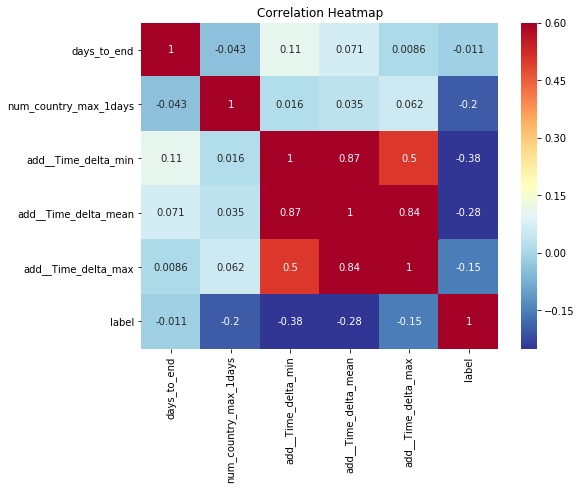

In [41]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');


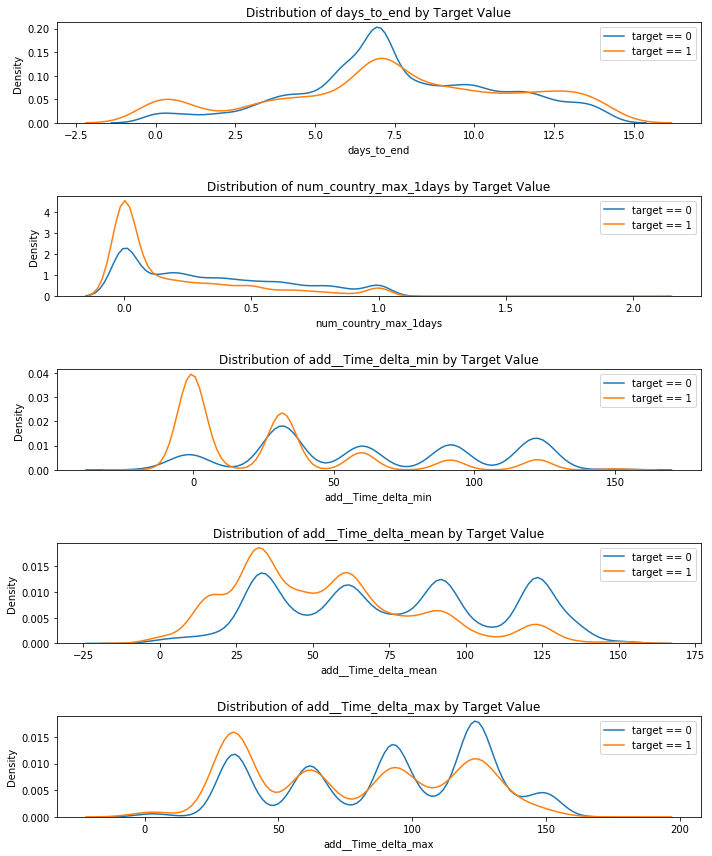

In [42]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['days_to_end','num_country_max_1days','add__Time_delta_min','add__Time_delta_mean','add__Time_delta_max']):
    
    # create a new subplot for each source
    plt.subplot(5, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train_base.loc[train_base['label'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train_base.loc[train_base['label'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

### Baseline model
I dacided to use light gbm because it doesn't take as much memory as XGBoost and it works well with sparse data

In [56]:
def model_lgb(train, test, random_state = 123, get_dummies = False, n_splits = 5, lgb_params = None):
    
    y = np.array(train['label'])
    
    if not lgb_params:
        lgb_params = { 'objective': 'binary', 'n_estimators':10000,  
                       #'class_weight': 'balanced', 
                      'is_unbalance': 'true',
                      'learning_rate': 0.05,
                       'subsample': 0.8,


    
                     }
    
    if get_dummies:
        train = pd.get_dummies(train)
        test = pd.get_dummies(test)
        
        
    X = train.drop(['email','label'], axis = 1) 
    col_names = list(X.columns)
    X = np.array(X) #  Works better with np.array if there are many features in dataset
    feature_importances = np.zeros(len(col_names))
    del train

    #  Data for predictions
    predict_test = np.array(test.drop(['email'], axis = 1))
    #  Init predictions array with all zeroes
    predictions = np.zeros(predict_test.shape[0])
    
    #  Here I store importance of each feature. It is also used for plotting bars of importance

    auc_score = 0

    print('Starting cross validation')

    kf = KFold(n_splits=n_splits, shuffle = True, random_state = random_state)

    for train_index, test_index in kf.split(X):
        #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        classifier = lgb.LGBMClassifier(** lgb_params )#** lgb_params 
        classifier.fit(X_train, y_train, 
                       # Validation params. Also used for early stopping
                       eval_set=[(X_test, y_test)], 
                       eval_names = ['kfold_test'],
                       eval_metric = 'auc',

                       early_stopping_rounds = 100,  
                       
                       # Output every N iterations
                       verbose = 400
                       )
        
        predictions = classifier.predict_proba(predict_test)[:,1]
        feature_importances += classifier.feature_importances_

        auc_score += classifier.best_score_['kfold_test']['auc']
        
        del X_train, X_test, y_train, y_test, classifier
    
    #  Avarage probabilities and auc score
    predictions = predictions / n_splits
    auc_score = auc_score / n_splits

    test['predictions'] = predictions
    
    #  Feature impotance in per cent
    feature_importances_percentage = feature_importances / np.sum(feature_importances)
    
    #  Create sorted by importance feature list 
    feature_importances = sorted(zip(list(feature_importances_percentage), col_names), reverse=True)
    feature_importances = pd.DataFrame(feature_importances, columns=['importance', 'feature'])
    
    return test[['email', 'predictions']],feature_importances, auc_score

def plot_feature_importances(df_fi, num_limit = None):
    ''' Plot feature importances barplot'''
    if not num_limit:
        num_limit = df_fi.shape[0]
        
    f, ax = plt.subplots(figsize=(12, num_limit / 2))
    
    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot( x="importance", y="feature", 
                data=df_fi[:num_limit], color="b"
               ).set_title('Feature importance')
    
    return df_fi

In [57]:
print(train_base.shape)
print(test_base.shape)

(19962, 167)
(10000, 166)


In [58]:
#test_base = test_base.drop(columns= 'predictions')

In [38]:
output,feature_importances, metrics = model_lgb(train_base, test_base, random_state = 123, get_dummies = False, n_splits = 5, lgb_params = None)

Starting cross validation
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	kfold_test's auc: 0.895101	kfold_test's binary_logloss: 0.392148
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	kfold_test's auc: 0.891339	kfold_test's binary_logloss: 0.396204
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	kfold_test's auc: 0.888198	kfold_test's binary_logloss: 0.405626
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[212]	kfold_test's auc: 0.881264	kfold_test's binary_logloss: 0.399687
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	kfold_test's auc: 0.880252	kfold_test's binary_logloss: 0.415386


In [39]:
output.head()

,email,predictions
0,000568a584,0.063874
1,0009f0da8c,0.010084
2,00106be5a4,0.018222
3,0012481017,0.023974
4,001aac3e5d,0.012744


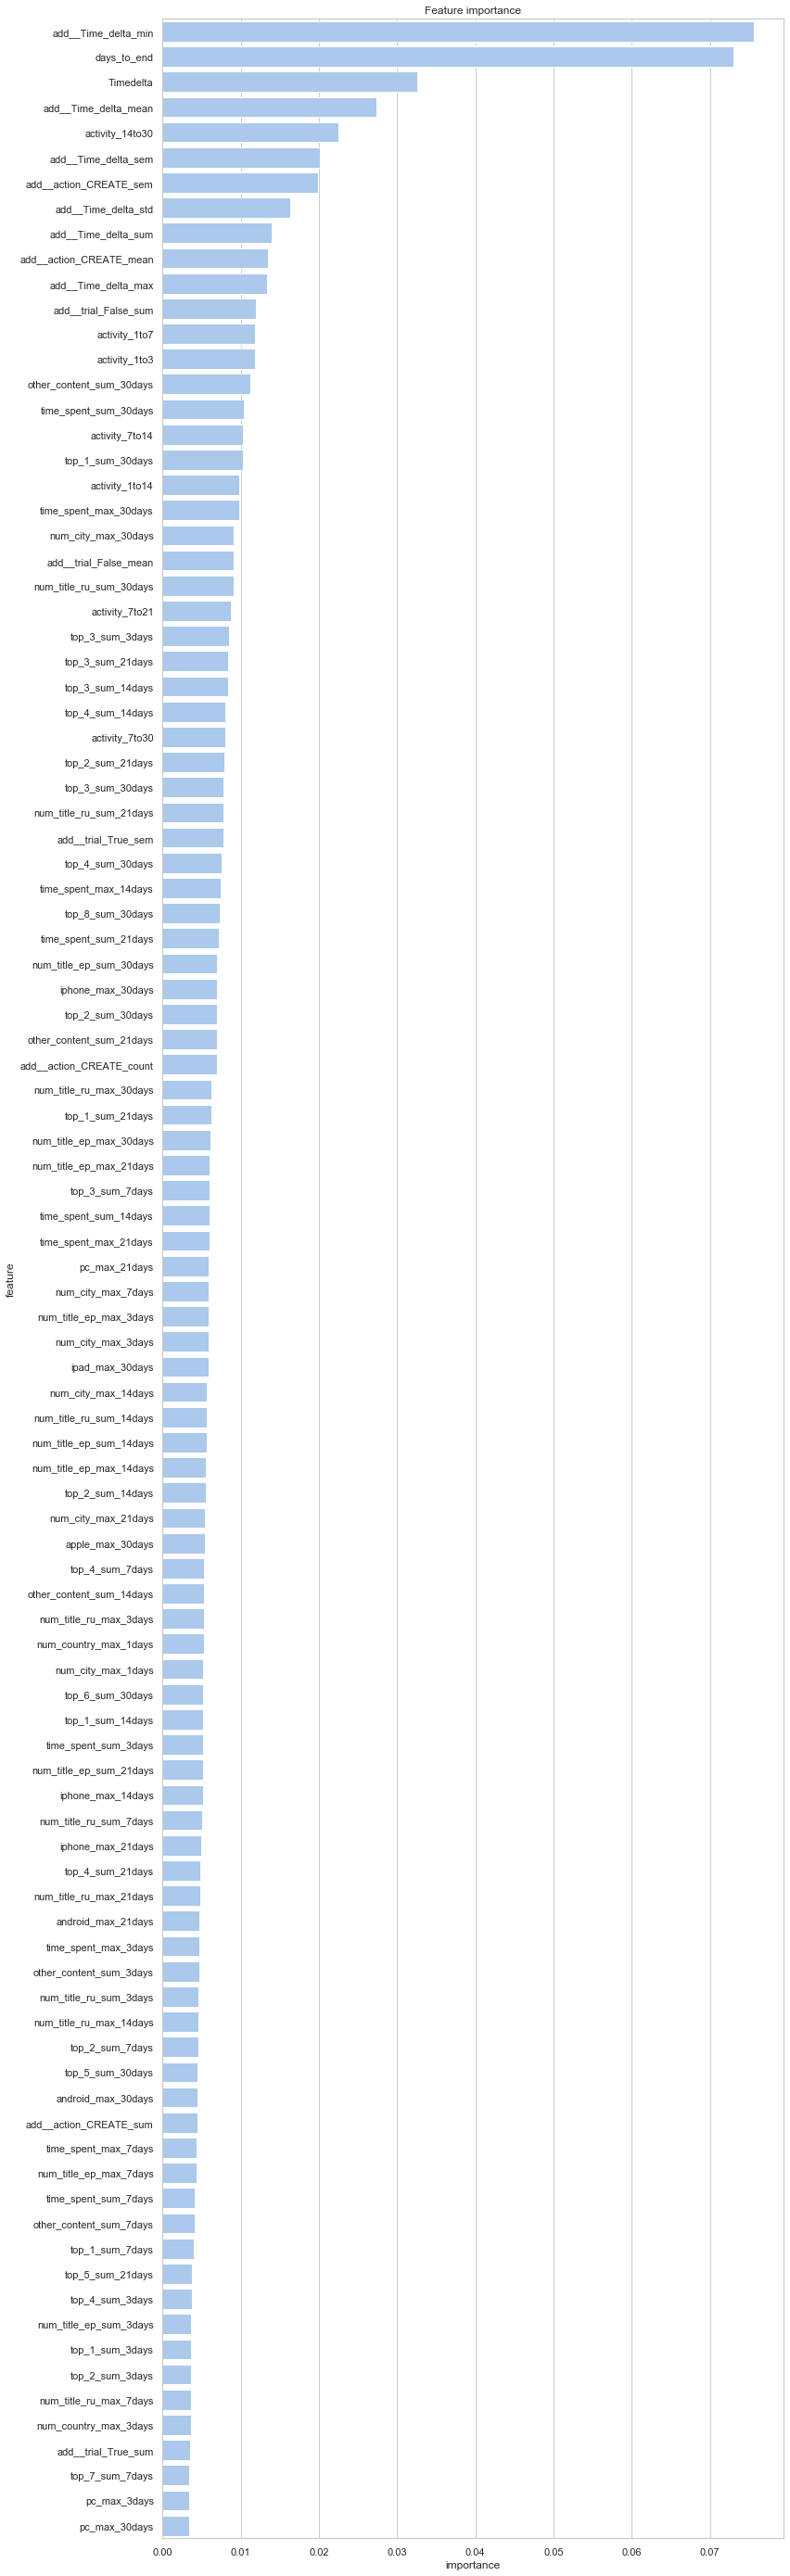

In [60]:
fi = plot_feature_importances(feature_importances, 100)

### Submit

In [41]:
output.to_csv('submit.csv')